# Week 8 - 28/11/17


**Main objectives:**

- Start thinking about population distributions

**Completed objectives:**

- Try optimising $m_b$ for a better fit - failed.
- Modify the analytical radiation model, we aren't subtracting the location on the edge of the disc (non-inclusive boundary?)
- Look into errors to see why they're so large for plotting ratio $\frac{\epsilon_{sim}}{\epsilon_{ana}}$ for gravity model
- Justification of approximation in gravity model
- Think a bit more about what happens in radiation model for n-n - look into the coded function to see what is happening here because it doesn't agree (maybe think about making one location slightly closer than the other)


In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from hm.analysis.explicit_tripoint import epsChangeXRatio_g, epsChangeX

## Optimising $m_b$ for a better fit

Made a chi-squared routine, but we're not sure whether this is justified (our values aren't frequencies) - chi-squared also gets trivially small for large $m_b$ obviously because of the way $m_b$ translates the graph up and down (relative differences are smaller for large and very small $m_b$). Also it seems to just suggest making $m_b$ arbitrarily large to produce a better fit - this isn't physical (or correct).

Just playing around with $\tilde{m_b}$ confirms this for the plots below.

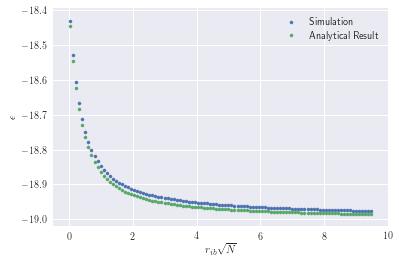

In [54]:
epsChangeX(0.001,0.3, 0.03, 100, 1000, gamma=2, exp=True, ib=True, analytical=True, tildeM=0.1)

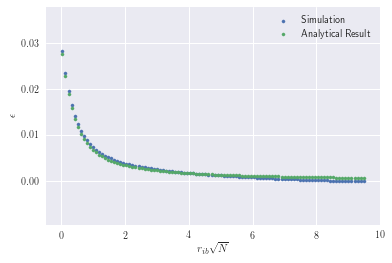

In [59]:
epsChangeX(0.001,0.3, 0.03, 100, 1000, gamma=2, exp=True, ib=True, analytical=True, tildeM=2)

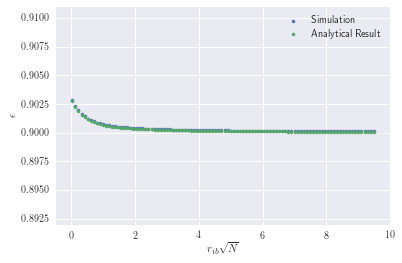

In [58]:
epsChangeX(0.001,0.3, 0.03, 100, 1000, gamma=2, exp=True, ib=True, analytical=True, tildeM=20)

So the ratio between the two becomes closer to unity, but the fit isn't necessarily better in absolute terms.

## Plotting ratio $\frac{\epsilon_{sim}}{\epsilon_{ana}}$ for gravity model - error analysis

Why are they so large?

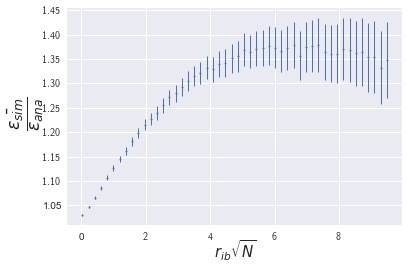

In [4]:
epsChangeXRatio_g(0.001,0.3, 0.03, 50, 1000, runs=50, gamma=2, exp=True, ib=True)

I've found the form for the ratio erros as

$$\sigma_{\text{ratio}} = \frac{\sigma_{\epsilon_{\text{sim}}}}{\epsilon_{\text{ana}}}$$

This is implemented in the code properly, it's probably just $\epsilon_{\text{ana}}$ becoming small. 

## Justification for gravity $\epsilon_{\text{ana}}$ approximation

We made an assumption in the derivation for $\epsilon_{\text{ana}}$ that

$$K_{ib} \approx K_{ij}.$$

Here I will justify this assumption by plotting the ratio between the two for various parameter values. 

In [2]:
from hm.analysis.eps_g_assmp_jus import *

First, for change in number of locations:

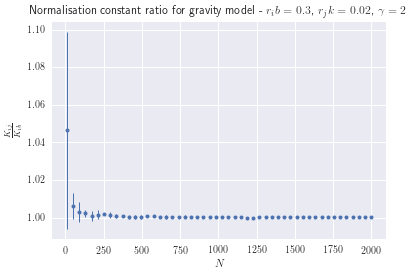

In [8]:
ratio_N(0.3,0.02,10,2000,50, runs=10)

Seems pretty resilient. Even at $N=10$ there is only a 5% error. For $N=1000$ (what I've been using), the error is negligible.

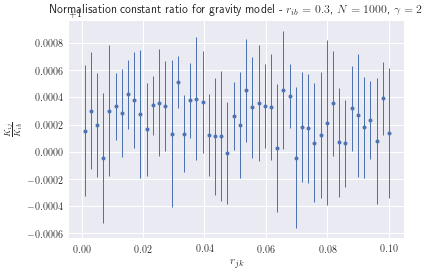

In [10]:
ratio_rjk(0.3, 0.001, 0.1, 50, N=1000, runs=10)

(Note that the $\frac{K_{ij}}{K_{ib}}$ axis is shifted by -1)

This again is a very small error, doesn't seem to be much variation with varying $r_{jk}$. Have looked into changes with $\gamma$ and the results are very similar.

**Conclusion:** Approximation is robust (<1% error) for $N\gtrapprox50$ 

## Looking into n-n behaviour for radiation model simulation

We found this wasn't behaving as expected, so I'm going to make a toy-model to test it.

In [2]:
from hm.pop_models.pop_explicit import explicit as pop_explicit
from hm.hm_models.radiation import radiation
from hm.analysis.explicit_tripoint import epsilon

In [2]:
# Tri-point arrangement with an extra external point
loc_d3 = [[0.5,0.5],[0.5,0.6],[0.5,0.4],[0.5,0.7]]
pop_d3 = [1,1,1,1]

#Two-point arrangement with the same extra external point
loc_d2 = [[0.5,0.5],[0.5,0.6],[0.5,0.7]]
pop_d2 = [1,2,1]

p3 = pop_explicit(loc_d3, pop_d3)
p2 = pop_explicit(loc_d2, pop_d2)

r3 = radiation(p3)
r2 = radiation(p2)

The radiation model looks like

$$T_{ij} = \frac{T_i}{1-\frac{m_i}{M}} \frac{m_i m_j}{(m_i + s_{ij})(m_i + m_j + s_{ij})}.$$

Let's set $A = \frac{T_i}{1-\frac{m_i}{M}}$, it's just a constant.

For $j$ and $k$ as nearest neighbours, $s_{ij} = s_{ib} = 0$. Therefore, $T_{ij} = T_{ik} = A \cdot \frac{1}{2}$ and $T_{ib} = A \cdot \frac{2}{3}$.

$$\epsilon = 1 - \frac{T_{ij} + T_{ik}}{T_{ib}},$$

so in this n-n case $\epsilon = 1 - \frac{A}{\frac{2}{3}A} = -\frac{1}{2}$. Now let's try this on the simulation.

In [3]:
epsilon(r2,r3, ib=True)

0.5

This is incorrect, let's try calculating it explicitly.

In [4]:
1 - (r3.flux(0,1)+r3.flux(0,2))/r2.flux(0,1)

0.5

In this case, $A = \frac{1}{1-\frac{1}{4}}=\frac{4}{3}$. $T_{ij} = \frac{4}{3} \cdot \frac{1}{2} = \frac{2}{3}$

In [5]:
r3.flux(0,1)

0.22222222222222221

wrong again, closing in on the issue.

In [10]:
popi, popj = p3.popDist[0], p3.popDist[1]
popSij = p3.s(0, 1)
n = (popi/(1-popi/p3.M()))*(popi*popj)/float((popi+popSij)*(popi+popSij+popj))

In [14]:
popSij

1

So it thinks popSij is unity which is wrong. Turns out the p.s() function has an *inclusive* boundary for the locations, so $k$ is included also, I've changed this now. Let's try again.

In [3]:
epsilon(r2,r3, ib=True)

-0.5

Ok, success! Now let's try replotting the radiation model graphs.

## Replotting the analytical form for radiaton model against corrected simulation

In [4]:
from hm.analysis.explicit_tripoint import epsChangeYRatio_r, epsChangeXRatio_r, epsChangeY_r, epsChangeX_r

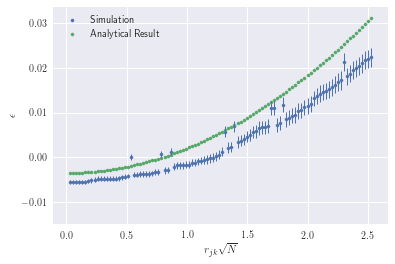

In [3]:
epsChangeY_r(0.001,0.08, 0.3, 100, 1000, runs=50, ib=True, analytical=True)

This still isn't *that* great, but it's better (at least it goes negative now).

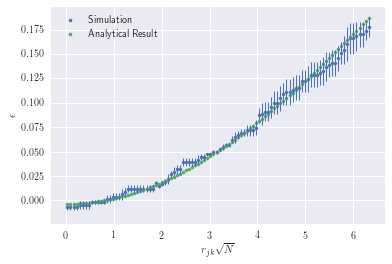

In [9]:
epsChangeY_r(0.001,0.2, 0.3, 100, 1000, runs=3, ib=True, analytical=True)

Works nicely for large $r_{jk}$, but we don't care about this range. Nice to know anyway.

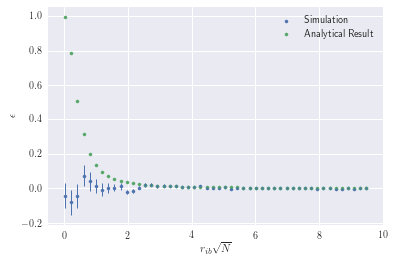

In [4]:
epsChangeX_r(0.001,0.3, 0.03, 50, 1000, runs=50, ib=True, analytical=True)

This is technically worse, but we might expect that, due to continuous approximation breaking down. It goes negative for small $r_{ib}$ but we expect it to tend to a constant $-\frac{1}{2}$ for n-n. Let's look a little closer.

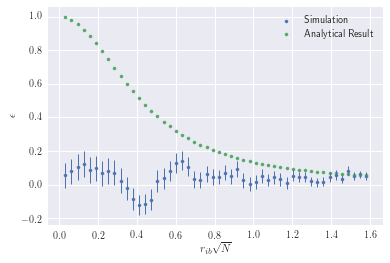

In [6]:
epsChangeX_r(0.001,0.05, 0.03, 50, 1000, runs=50, ib=True, analytical=True)

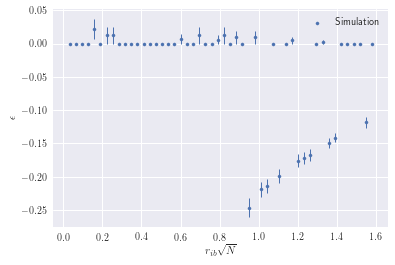

In [9]:
epsChangeX_r(0.001,0.05, 0.003, 50, 1000, runs=50, ib=True, analytical=False)

Don't really know what's going on here, maybe we don't care. $\epsilon$ is still significant for typical $r_{ib}$, which is what we're looking at. Should try more runs in future.

Now for the ratios, will still have some singularities somewhere but we can probably ignore this.

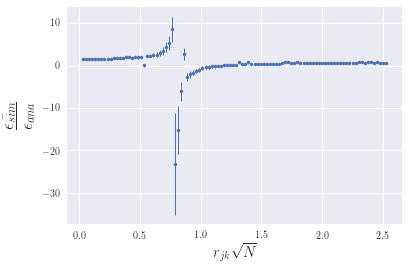

In [7]:
epsChangeYRatio_r(0.001,0.08, 0.3, 100, 1000, runs=50, ib=True)

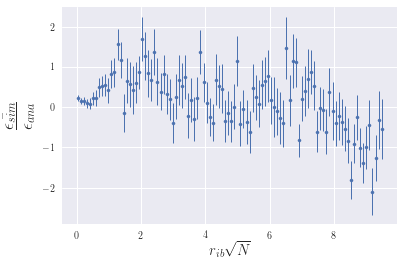

In [8]:
epsChangeXRatio_r(0.001,0.3, 0.03, 100, 1000, runs=50, ib=True)

These really aren't great, but again, perhaps this is what we expect anyway. 

**In conclusion:** the $\epsilon$ analytical result for  

**Tim's Comments**

- Try a few fitting stats
- Practical examples for the error, from real cities